In [1]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image, ImageColor

In [2]:
parts = {10: {'col': 'orange', 'name':'hood'}, 
         20: {'col':'darkgreen', 'name':'front door'}, 
         30: {'col':'yellow', 'name':'rear door'}, 
         40: {'col':'cyan', 'name':'frame'}, 
         50: {'col':'purple', 'name':'rear quarter panel'}, 
         60: {'col':'lightgreen', 'name':'trunk lid'}, 
         70: {'col':'blue', 'name':'fender'}, 
         80: {'col':'pink', 'name':'bumper'}, 
         90: {'col':'darkgray', 'name':'rest of car'},
         0 : {'col':'black', 'name':'background'}}

def display_car(data_arr):
    # Can take both full data and already split data
    if type(data_arr) == torch.Tensor: data_arr = np.moveaxis(data_arr.numpy().astype(np.uint8), 0, 2)
    elif data_arr.shape[0] == 3: data_arr = np.moveaxis(data_arr.astype(np.uint8), 0, 2)
    elif data_arr.shape[2] > 3: data_arr = data_arr[:,:,:3]
    img = Image.fromarray(data_arr)
    display(img) # img.show() for jupyter
    
def display_labels(data_arr):
    # Can take both full data and already split data
    if type(data_arr) == torch.Tensor: data_arr = data_arr.numpy()
    if data_arr.dtype != np.uint8: data_arr = data_arr.astype(np.uint8)*10
    if data_arr.ndim > 2: data_arr = data_arr[:,:,3]
    img = Image.fromarray(data_arr)
    pixels = list(img.getdata())
    pixels = [ImageColor.getrgb(parts.get(pixel)['col']) for pixel in pixels]
    image = Image.new("RGB", (256, 256), (0,0,0))
    image.putdata(pixels)
    display(image)
    
def numpy_to_tensor(arr):
    return np.moveaxis(arr, 2, 0).astype(np.float32)

def tensor_to_numpy(tens):
    arr = np.moveaxis(tens, 0, 2).astype(np.uint8)
    return arr

In [3]:
import os
import numpy as np
from torch.utils.data import Dataset
from skimage.transform import resize

class CarDataset(Dataset):
    def __init__(self, root, file_list: list=None):
        self.root = root
        self.filenames = os.listdir(self.root) if file_list is None else file_list
        
    def __len__(self):
        return len(self.filenames)
        
    def __getitem__(self, index):
        filename = self.filenames[index]
        arr = np.load(os.path.join(self.root, filename))
        car = arr[:,:,0:3]
        # Resize function does not work on int dtypes, so we must convert to float before
        car = resize(car.astype(np.float32), (256, 256))
        # Convert to the torch tensor image convention (CxWxH)
        car = np.moveaxis(car, 2, 0)
        labels = arr[:,:,3]
        labels = resize(labels.astype(np.float32), (256, 256))
        
        return torch.tensor(car), torch.tensor(labels/10)

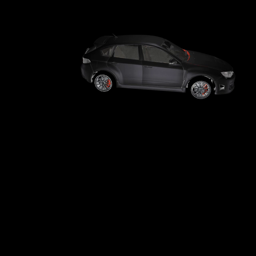

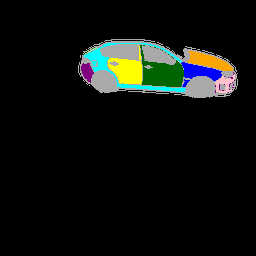

In [4]:
ds = CarDataset('./carseg_data-2/arrays')
car, labels = ds[0]
display_car(car)
display_labels(labels)

In [5]:
from torch import nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        self.encoder0 = nn.Sequential(ConvBlock(in_channels, 64))
        self.encoder1 = nn.Sequential(nn.MaxPool2d(2,2), ConvBlock(64, 128))
        self.encoder2 = nn.Sequential(nn.MaxPool2d(2,2), ConvBlock(128, 256))
        self.bottleneck = nn.Sequential(nn.MaxPool2d(2,2), ConvBlock(256,512), nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2))
        self.decoder0 = nn.Sequential(ConvBlock(512,256), nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2))
        self.decoder1 = nn.Sequential(ConvBlock(256,128), nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2))
        self.decoder2 = nn.Sequential(ConvBlock(128,64), nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1))
        
    def forward(self, x):
        # Add dimension if input is not batched
        if x.ndim == 3: x = x.unsqueeze(0)
            
        x0 = self.encoder0(x)
        x1 = self.encoder1(x0)
        x2 = self.encoder2(x1)
        x3 = self.bottleneck(x2)
        x3 = self.decoder0(torch.cat([x2,x3],dim=1))
        x3 = self.decoder1(torch.cat([x1,x3],dim=1))
        x3 = self.decoder2(torch.cat([x0,x3],dim=1))
        
        return x3
    
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.block(x)

In [6]:
black_car = []
orange_car = []
photos = []
for file in os.listdir('./carseg_data-2/arrays'):
    if 'orange' in file: orange_car.append(file)
    elif 'black' in file: black_car.append(file)
    elif 'photo' in file: photos.append(file)

print(len(black_car), len(orange_car), len(photos))

834 2001 168


In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

root = './carseg_data-2/arrays'

photo_train, photo_test = train_test_split(photos, test_size=0.2, random_state=42)
black_train, black_test = train_test_split(black_car, test_size=0.2, random_state=42)
orange_train, orange_test = train_test_split(orange_car, test_size=0.2, random_state=42)

joint_train_ds = CarDataset(root, photo_train+black_train+orange_train)
joint_test_ds = CarDataset(root, photo_test+black_test+orange_test)
photo_test_ds = CarDataset(root, photo_test)
black_test_ds = CarDataset(root, black_test)
orange_test_ds = CarDataset(root, orange_test)

train_dl = DataLoader(joint_train_ds, batch_size=16, shuffle=True)
test_dl = DataLoader(joint_test_ds, batch_size=16)

In [10]:
device = torch.device('cuda')

model = UNet(3,10).to(device)
model.load_state_dict(torch.load('./Models/checkpoint/model_19_epochs_dice_09575.pth'))
with torch.inference_mode():
    dice_scores = []
    for car, label in photo_test_ds:
        car = car.to(device)
        label = label.to(device)
        out = torch.nn.Softmax2d()(model(car))
        dice_score = dice(out, label.int())
        dice_scores.append(dice_score.cpu())
    print('Photo ds mean Dice: ',np.mean(dice_scores))
    
    for car, label in black_test_ds:
        car = car.to(device)
        label = label.to(device)
        out = torch.nn.Softmax2d()(model(car))
        dice_score = dice(out, label.int())
        dice_scores.append(dice_score.cpu())
    print('Black ds mean Dice: ',np.mean(dice_scores))

Photo ds mean Dice:  0.71035093
Black ds mean Dice:  0.8981885


This is the same as the previous cell but in cpu...

In [9]:
from torchmetrics.functional import dice

model = UNet(3,10)
model.load_state_dict(torch.load('./Models/checkpoint/model_19_epochs_dice_09575.pth'))
with torch.inference_mode():
    dice_scores = []
    for car, label in photo_test_ds:
        out = torch.nn.Softmax2d()(model(car))
        dice_score = dice(out, label.int())
        dice_scores.append(dice_score)
    print('Photo ds mean Dice: ',np.mean(dice_scores))
    
    for car, label in black_test_ds:
        out = torch.nn.Softmax2d()(model(car))
        dice_score = dice(out, label.int())
        dice_scores.append(dice_score)
    print('Black ds mean Dice: ',np.mean(dice_scores))

KeyboardInterrupt: 